<a href="https://colab.research.google.com/github/SatadruMukherjee/Data-Preprocessing-Models/blob/main/Monitor_Data_Pipeline_using_CloudWatch_Custom_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.3 MB/s eta 0:00:00


# **Monitor your Data Pipeline**

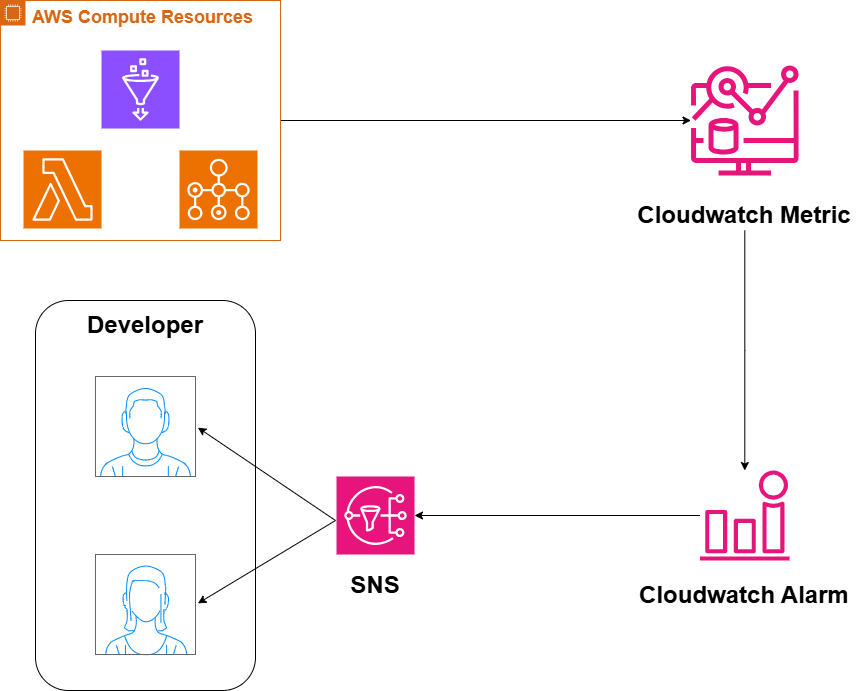

# **Namespaces** -- A namespace is a container for CloudWatch metrics. Metrics in different namespaces are isolated from each other, so that metrics from different applications are not mistakenly aggregated into the same statistics.

# **Metrics** -- Metrics are the fundamental concept in CloudWatch. A metric represents a time-ordered set of data points that are published to CloudWatch. Think of a metric as a variable to monitor, and the data points as representing the values of that variable over time

# **Dimensions** -- Dimensions are the name-value pair that seperate data points for different things within same matric

In [3]:
import boto3

def write_to_cloudwatch(namespace, metric_name, dimensions, value, unit):
    """Logs metric data to AWS CloudWatch."""
    cloudwatch_client = boto3.client(
        'cloudwatch',
        aws_access_key_id='',
        aws_secret_access_key='',
        region_name='us-east-1'
    )

    try:
        response = cloudwatch_client.put_metric_data(
            Namespace=namespace,
            MetricData=[
                {
                    'MetricName': metric_name,
                    'Dimensions': dimensions,
                    'Value': value,
                    'Unit': unit,
                },
            ]
        )
        print("Successfully logged metric to CloudWatch.")
        return response
    except Exception as e:
        print(f"Failed to write metric to CloudWatch: {e}")
        return None

# Main code
try:
    #print("Success")
    print(0 / 0)
    dimensions = [
        {
            'Name': 'JobName',
            'Value': '123'
        }
    ]
    write_to_cloudwatch(
        namespace='PET_DataPipelines',
        metric_name='DataPipelineSuccessMetrices',
        dimensions=dimensions,
        value=1,
        unit='Count'
    )
except Exception as e:
    print("Failed")
    dimensions = [
        {
            'Name': 'JobName',
            'Value': '123'
        }
    ]
    write_to_cloudwatch(
        namespace='PET_DataPipelines',
        metric_name='DataPipelineFailureMetrices',
        dimensions=dimensions,
        value=1,
        unit='Count'
    )


Failed
Successfully logged metric to CloudWatch.


In [ ]:
import json
import boto3
import logging
from botocore.exceptions import ClientError
logger = logging.getLogger()
logger.setLevel(logging.INFO)
def get_user_name(event):
    if 'userIdentity' in event['detail']:
        if event['detail']['userIdentity']['type'] == 'AssumedRole':
            user_name = str('UserName: ' + event['detail']['userIdentity']['principalId'].split(':')[1] + ', Role: ' + event['detail']['userIdentity']['sessionContext']['sessionIssuer']['userName'] + ' (role)')
        elif event['detail']['userIdentity']['type'] == 'IAMUser':
            user_name = event['detail']['userIdentity']['userName']
        elif event['detail']['userIdentity']['type'] == 'Root':
            user_name = 'root'
        else:
            logging.info('Could not determine username (unknown iam userIdentity) ')
            user_name = ''
    else:
        logging.info('Could not determine username (no userIdentity data in cloudtrail')
        user_name = ''
    return user_name
def lambda_handler(event, context):
    client = boto3.client('cloudtrail')
    resource_type = event["detail"]["eventSource"]
    user_name=get_user_name(event)
    if resource_type == "lambda.amazonaws.com":
        resource_arn = event["resources"][0]
        resource_name = event["detail"]["configurationItem"]["configuration"]["functionName"]
        try:
            client = boto3.client('lambda')
            client.tag_resource(
                Resource=resource_arn,
                Tags={'Created_by': user_name}
            )
            logging.info(f"Lambda function {resource_name} tagged with username : {user_name}")
        except ClientError as e:
            logging.error(f"Error tagging Lambda function {resource_name}: {e}")